In [1]:
import numpy as np
import cirq

from recirq.hfvqe.gradient_hf import rhf_func_generator
from recirq.hfvqe.opdm_functionals import OpdmFunctional
from recirq.hfvqe.analysis import (
    compute_opdm, mcweeny_purification,
    resample_opdm, fidelity_witness,
    fidelity)
from recirq.hfvqe.third_party.higham import fixed_trace_positive_projection
from recirq.hfvqe.molecular_example import make_h6_1_3

In [2]:
rhf_objective, molecule, parameters, obi, tbi = make_h6_1_3()
ansatz, energy, gradient = rhf_func_generator(rhf_objective)

# settings for quantum resources
qubits = [cirq.GridQubit(0, x) for x in range(molecule.n_orbitals)]
sampler = cirq.Simulator(dtype=np.complex128)  # this can be a QuantumEngine

# OpdmFunctional contains an interface for running experiments
opdm_func = OpdmFunctional(qubits=qubits,
                           sampler=sampler,
                           constant=molecule.nuclear_repulsion,
                           one_body_integrals=obi,
                           two_body_integrals=tbi,
                           # only simulate spin-up electrons:
                           num_electrons=molecule.n_electrons // 2,
                           clean_xxyy=True,
                           purification=True
                           )

Optimization terminated successfully.
         Current function value: -2.924060
         Iterations: 7
         Function evaluations: 15
         Gradient evaluations: 15


In [3]:
# 1.
# default to 250_000 shots for each circuit.
# 7 circuits total, printed for your viewing pleasure
# return value is a dictionary with circuit results for each permutation
measurement_data = opdm_func.calculate_data(parameters)

# 2.
opdm, var_dict = compute_opdm(measurement_data, return_variance=True)
opdm_pure = mcweeny_purification(opdm)

# 3.
raw_energies = []
raw_fidelity_witness = []
purified_eneriges = []
purified_fidelity_witness = []
purified_fidelity = []
true_unitary = ansatz(parameters)
nocc = molecule.n_electrons // 2
nvirt = molecule.n_orbitals - nocc
initial_fock_state = [1] * nocc + [0] * nvirt

# 1000 repetitions of the measurement
for _ in range(1000):  
    new_opdm = resample_opdm(opdm, var_dict)
    raw_energies.append(opdm_func.energy_from_opdm(new_opdm))
    raw_fidelity_witness.append(
        fidelity_witness(target_unitary=true_unitary,
                         omega=initial_fock_state,
                         measured_opdm=new_opdm)
    )
    # fix positivity and trace of sampled 1-RDM if strictly outside
    # feasible set
    w, v = np.linalg.eigh(new_opdm)
    if len(np.where(w < 0)[0]) > 0:
        new_opdm = fixed_trace_positive_projection(new_opdm, nocc)

    new_opdm_pure = mcweeny_purification(new_opdm)
    purified_eneriges.append(opdm_func.energy_from_opdm(new_opdm_pure))
    purified_fidelity_witness.append(
        fidelity_witness(target_unitary=true_unitary,
                         omega=initial_fock_state,
                         measured_opdm=new_opdm_pure)
    )
    purified_fidelity.append(
        fidelity(target_unitary=true_unitary,
                 measured_opdm=new_opdm_pure)
    )
print("Canonical Hartree-Fock energy ", molecule.hf_energy)
print("True energy ", energy(parameters))
print("Raw energy ", opdm_func.energy_from_opdm(opdm),
      "+- ", np.std(raw_energies))
print("Raw fidelity witness ", np.mean(raw_fidelity_witness).real,
      "+- ", np.std(raw_fidelity_witness))
print("purified energy ", opdm_func.energy_from_opdm(opdm_pure),
      "+- ", np.std(purified_eneriges))
print("Purified fidelity witness ", np.mean(purified_fidelity_witness).real,
      "+- ", np.std(purified_fidelity_witness))
print("Purified fidelity ", np.mean(purified_fidelity).real,
      "+- ", np.std(purified_fidelity))

/tmp/ipykernel_2049/2348574811.py:8: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  opdm, var_dict = compute_opdm(measurement_data, return_variance=True)
/tmp/ipykernel_2049/2348574811.py:8: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  opdm, var_dict = compute_opdm(measurement_data, return_variance=True)
/tmp/ipykernel_2049/2348574811.py:8: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  opdm, var_dict = compute_opdm(measurement_data, return_variance=True)
/tmp/ipykernel_2049/2348574811.py:8: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  opdm, var_dict = compute_opdm(measurement_data, return_variance=True)
/tmp/ipykernel_2049/2348574811.py:8: DeprecationWarning: `alltrue` i

Canonical Hartree-Fock energy  -2.9240604849733085
True energy  -2.9240604849722285
Raw energy  -2.9246902808731647 +-  0.0015119777791862427
Raw fidelity witness  1.0021661947148985 +-  0.0020616046796291723
purified energy  -2.9240427709725982 +-  9.691513666695864e-06
Purified fidelity witness  0.9999651716754931 +-  1.2269393863063033e-05
Purified fidelity  0.999982586496264 +-  6.134595581661331e-06


In [4]:
from recirq.hfvqe.mfopt import moving_frame_augmented_hessian_optimizer
from recirq.hfvqe.opdm_functionals import RDMGenerator

rdm_generator = RDMGenerator(opdm_func, purification=True)
opdm_generator = rdm_generator.opdm_generator

result = moving_frame_augmented_hessian_optimizer(
    rhf_objective=rhf_objective,
    initial_parameters=parameters + 1.0E-1,
    opdm_aa_measurement_func=opdm_generator,
    verbose=True, delta=0.03,
    max_iter=20,
    hessian_update='diagonal',
    rtol=0.50E-2)


ITERATION NUMBER :  0

 unitary
[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]
Current Energy:  -2.826268166288844
true energy  -2.8262712927716622
dvec
[((0.1278113177973088+0j), -1.0 [0^ 6] +
-1.0 [1^ 7] +
1.0 [6^ 0] +
1.0 [7^ 1]), ((0.14967026201776473+0j), -1.0 [2^ 6] +
-1.0 [3^ 7] +
1.0 [6^ 2] +
1.0 [7^ 3]), ((0.10954284802130045+0j), -1.0 [4^ 6] +
-1.0 [5^ 7] +
1.0 [6^ 4] +
1.0 [7^ 5]), ((0.33448867604840976+0j), -1.0 [0^ 8] +
-1.0 [1^ 9] +
1.0 [8^ 0] +
1.0 [9^ 1]), ((0.14038778575032118+0j), -1.0 [2^ 8] +
-1.0 [3^ 9] +
1.0 [8^ 2] +
1.0 [9^ 3]), ((0.2629010113758772+0j), -1.0 [4^ 8] +
-1.0 [5^ 9] +
1.0 [8^ 4] +
1.0 [9^ 5]), ((0.20587372459755487+0j), -1.0 [0^ 10] +
-1.0 [1^ 11] +
1.0 [10^ 0] +
1.0 [11^ 1]), ((0.2186394292401788+0j), -1.0 [2^ 10] +
-1.0 [3^ 11] +
1.0 [10^ 2] +
1.0 [11^ 3]), ((0.23781492643363744+0j), -1.0 [4^ 10] +
-1.0 [5^ 11] +
1.0 [10^ 4] +
1.0 [11^ 5])]
New fr values norm
0.051986

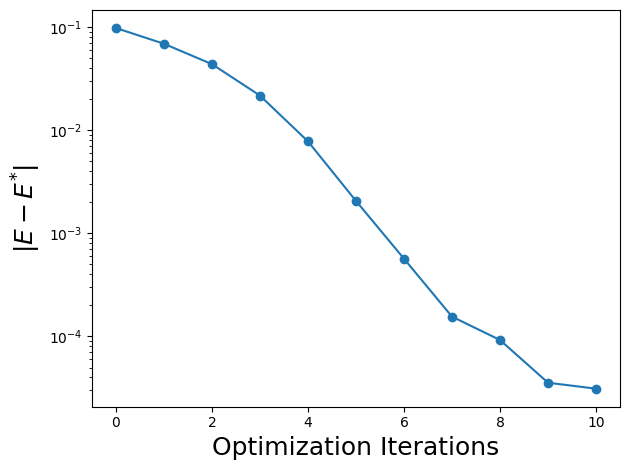

In [5]:
import matplotlib.pyplot as plt

plt.semilogy(range(len(result.func_vals)),
             np.abs(np.array(result.func_vals) - energy(parameters)),
             'C0o-')
plt.xlabel("Optimization Iterations",  fontsize=18)
plt.ylabel(r"$|E  - E^{*}|$", fontsize=18)
plt.tight_layout()
plt.show()